# Introduction to FGC: Comparison of Forest-Guided Clustering and Feature Importance

In this Notebook we will compare our Forest-Guided Clustering algorithm to the standard explainablity method permutation feature importance and Random forest specific feature importance.

**Note:** for installation description and a general introduction to FGC please have a look at [Read the Docs - Installation](https://forest-guided-clustering.readthedocs.io/en/latest/_getting_started/installation.html) and [Introduction Notebook](https://github.com/HelmholtzAI-Consultants-Munich/fg-clustering/blob/main/tutorials/introduction_to_FGC_use_cases.ipynb).

**Imports:**

In [1]:
# Load the required packages

import pandas as pd

from palmerpenguins import load_penguins

from fgclustering import FgClustering
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from utils.utils import * 

import warnings
warnings.filterwarnings('ignore')

## The Palmer Pinguins Dataset: Data Pre-Processing and Model Training

In this notebook, we will work with the **Palmer penguins dataset**, containing the information on 3 different species of penguins - Adelie, Chinstrap, and Gentoo - which were observed in the Palmer Archipelago near Palmer Station, Antarctica. The dataset consist of a total of 344 penguings, together with their size measurements, clutch observations, and blood isotope ratios. Our goal is to predict the species of Palmer penguins and find out the major differences among them.

<center><img src="https://raw.githubusercontent.com/HelmholtzAI-Consultants-Munich/fg-clustering/main/docs/source/_figures/penguins.png" width="500" /></center>

<font size=1> Source:[Link](https://allisonhorst.github.io/palmerpenguins/)


In [2]:
# Load the data
data_penguins = load_penguins()

# Inspect the data
data_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Before we start training the model, we need to do some preprocessing of our dataset. First, we need to take care of the missing values. In this example, we will apply the most common approach and simply omit those cases with the missing data and analyse the remaining data. In addition, categorical features need to be encoded, i.e. turned into numerical data. Here, we will use a simple dummy encoding for the categorical features, which will transform the categorical feature values into one-hot encoded vectors. 

In [3]:
# Remove the instances with missing values and check how many we are left with
print(f"Before omiting the missing values the dataset has {data_penguins.shape[0]} instances")
data_penguins.dropna(inplace=True)
print(f"After omiting the missing values the dataset has {data_penguins.shape[0]} instances")

# preprocess categorical features such that they can be used for the RF model
data_penguins_encoded = pd.get_dummies(data_penguins, columns=['island', 'sex'], prefix=['island', 'sex'], drop_first=True)

Before omiting the missing values the dataset has 344 instances
After omiting the missing values the dataset has 333 instances


Now we are ready to train our Random Forest model! First, we define a small grid of hyperparameters that is used for model optimization. For demonstration pupose, we define a rather small grid of hyperparameters. Then, we define an instance of the RandomForestClassifier and run the GridSearchCV with the 5-fold cross validation to tune the model on the pre-defined set of hyperparameters. The model with the best hyperparameters is saved as the _best_estimator__ in the GridSearchCV instance. 

In [4]:
# Grid of hyperparameters 
hyper_grid_classifier = {'n_estimators': [100, 1000], 
            'max_depth': [2, 5, 10], 
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt','log2']
}

In [5]:
# A Random Forest instance from sklearn requires a separate input of feature matrix and target values. 
# Hence, we will first separate the target and feature columns. 
X_penguins = data_penguins_encoded.loc[:, data_penguins_encoded.columns != 'species']
y_penguins = data_penguins_encoded.species

# Define a classifier. We set the oob_score = True, as OOB is a good approximation of the test set score
classifier = RandomForestClassifier(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42, n_jobs=1)

# Define a grid search with 5-fold CV and fit 
gridsearch_classifier = GridSearchCV(classifier, hyper_grid_classifier, cv=5, verbose=1)
gridsearch_classifier.fit(X_penguins, y_penguins)

# Take the best estimator
rf = gridsearch_classifier.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [6]:
# Check the results
print('out-of-bag accuracy of prediction model:')
print(rf.oob_score_)

out-of-bag accuracy of prediction model:
0.993993993993994


Great, now you trained your Random Forest model! And it scored with the high out-of-bag accuracy of 99%! 

But - is that all? Don't we want to know more? What about the explainability and deriving some knowledge out of it? Let us dive into the interpretation :)

## Interpreting Random Forest models with Feature Importance

### Permutation Feature Importance

Permutation Feature Importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. Now it is time to see how it works on the penguins dataset. 

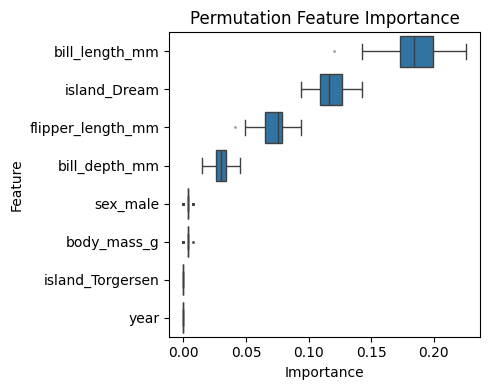

In [7]:
result = permutation_importance(rf, X_penguins, y_penguins, n_repeats=50, max_samples = 0.8, random_state=42)
plot_permutation_feature_importance(result=result, data=X_penguins, title="Permutation Feature Importance")

### Random Forest Feature Importance


An alternative for Permutation Feature Importance is the Random Forest specific Feature Importance method based on the mean decrease in impurity. The mean decrease in impurity is defined as the total decrease in node impurity averaged over all trees of the ensemble. This Feature Importances is directly provided by the fitted attribute _feature_importances__ .

Lets plot the feature importance based on mean decrease in impurity:

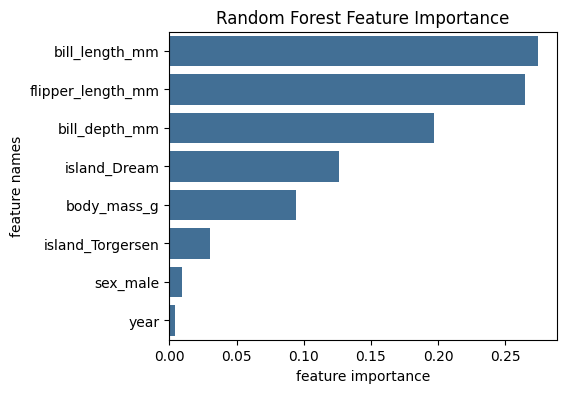

In [8]:
plot_impurity_feature_importance(rf.feature_importances_, names=X_penguins.columns, title="Random Forest Feature Importance")

We can see that the Random Forest Feature Importance identifies more important features than the Permutation Feature Importance. It seems that the feature importance of the correlated features flipper_length and body_mass are artificially lower in the Permutation Feature Importance due to the high correlation. Random Forest Feature Importance does not seem to be affected by this correlation effect. This shows that Permutation Feature Importance results should be interpreted with great care in the presence of correlated features.

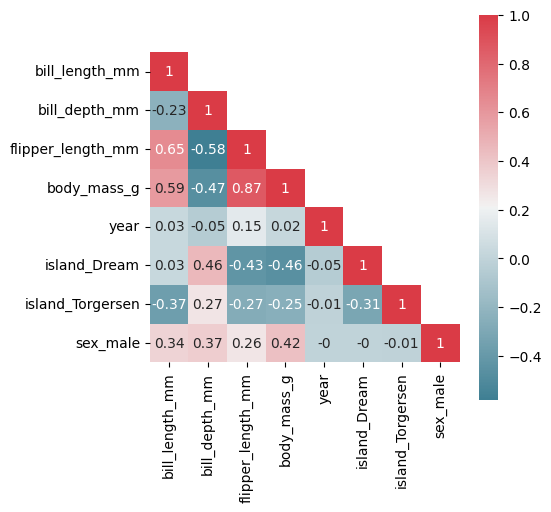

In [9]:
plot_correlation_matrix(X_penguins)

Even though the Random Forest Feature Importance does overcome some disadvantages of Permutation Feature Importance, it does not give us more information about the class-specific differences and further insights into the decision paths of the Random Forest model. Therefore, we developed a Random Forest specific interpretability method called Forest-Guided Clustering (FGC) that leverages the tree structure of Random Forest models to get insights into the decision making process of the model. Let us dive into the method... 

## Interpreting Random Forest models with Forest-Guided Clustering

We will use FGC to gain more insights into the decision making process of the Random Forest model we trained previously. Afterwards, we will compare the feature importance results obtained by the previous methods and with FGC.

In [10]:
# create an FGC instance
fgc = FgClustering(model=rf, data=X_penguins, target_column=y_penguins)

Interpreting RandomForestClassifier


FGC is based on the K-Medoids clustering algorithm, which requires a predefined number of clusters as input. FGC is able to optimize the number of clusters based on a scoring function, which is minimizing the model bias while restricting the model complexity. The argument _number_of_clusters_ is used to either pass the predefined number of clusters or should be left empty if optimization is desired. 

For the sake of example and since the optimization part takes some time, we will set the number of cluster equal to the number of species present in the penguins dataset.

In [11]:
# Run the fgc instance:
fgc.run(k=3)

# covert dummy encoded features back to category and recalculate p-value statistics
data_penguins['island'] = data_penguins['island'].astype('category')
data_penguins['sex'] = data_penguins['sex'].astype('category')

fgc.calculate_statistics(data=data_penguins, target_column='species')

Use 3 as number of cluster


FGC provides couple of ways to visualise the results and help interpret them:

- visualise global and local feature importance: features that show different and concise value distributions across clusters are defined to be globally or locally important
- reveal the decision rules of RF model by visualizing feature patterns per cluster

### Global and Local Feature importance provided by FGC

**Global feature importance** is represented as the significance of the difference between cluster-wise feature distributions as a measure of global feature importance (ANOVA for continuous features and chi square for categorical features). **Features which have significantly different distributions across clusters have a high feature importance**, while features which have a similar feature distribution across clusters have a low feature importance.

In addition to the global feature importance, we also provide a **local feature importance**, which gives the **importance of each feature for each cluster**. Here, a feature is considered important if its distribution in a particlular cluster is clearly different from the feature distribution in the whole dataset.

Please note that the importance is defined as:
$$
 - log10(\text{p-value} + \epsilon) / - log10(\epsilon)
$$

Therefore, the more significant difference across clusters the feature shows (the smaller the _p_-value), the closer the importance of the feature is to 1. 

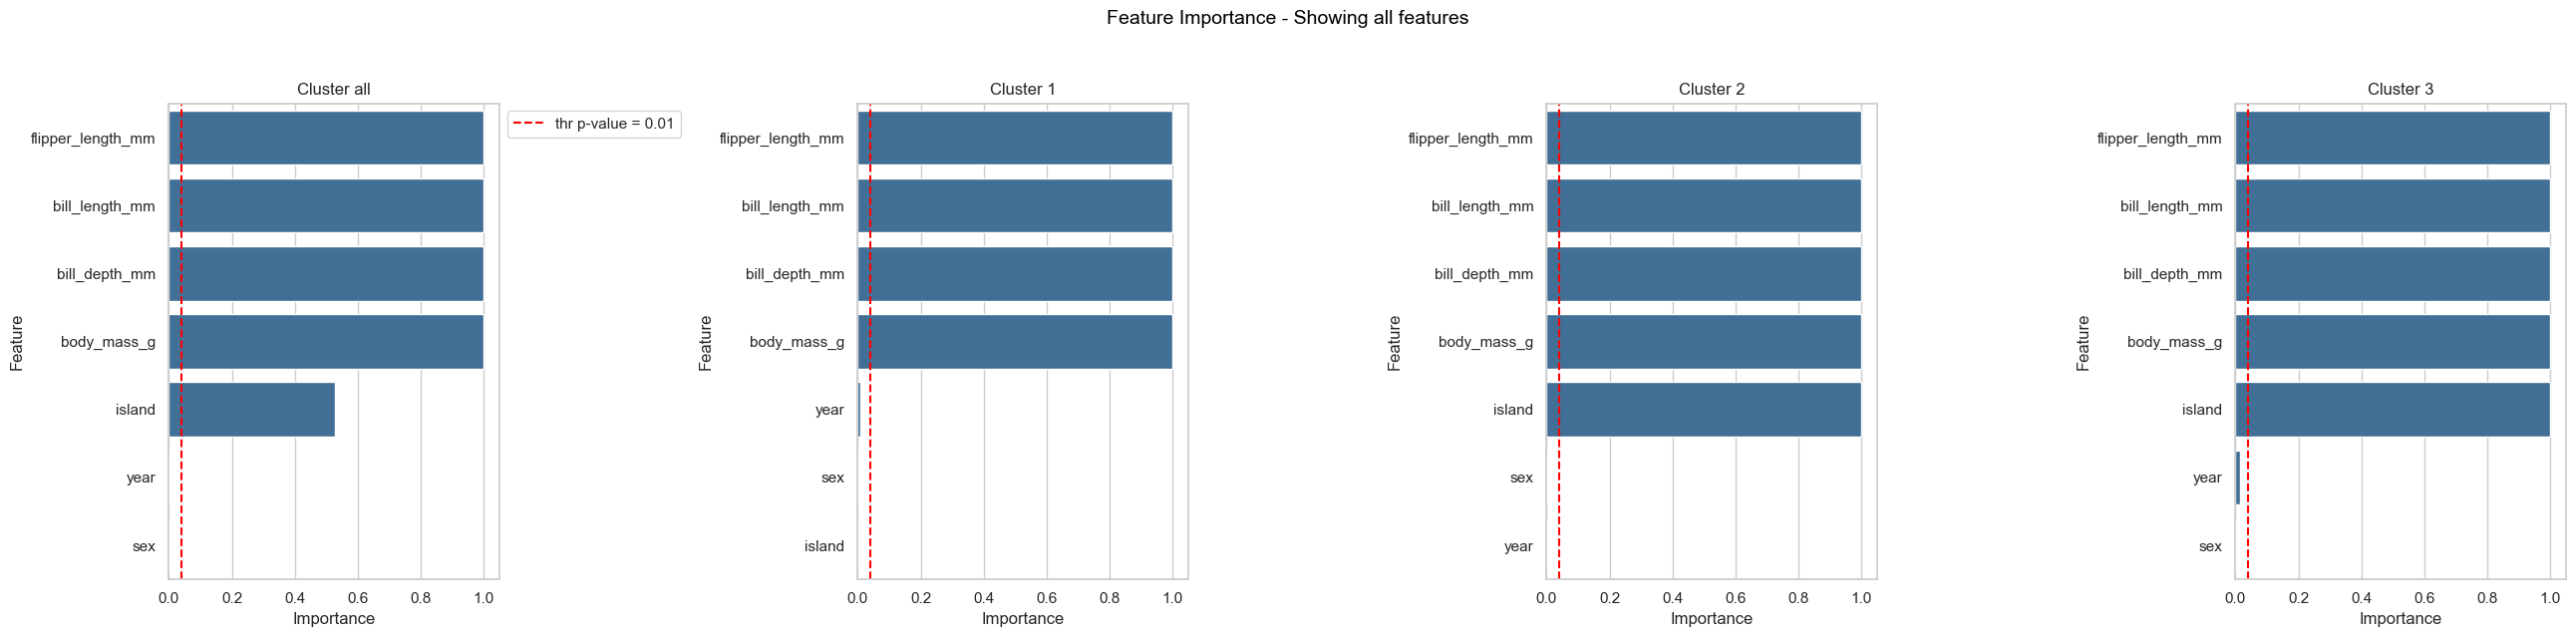

In [12]:
%matplotlib inline
# Plot global and local feature importance
fgc.plot_feature_importance(thr_pvalue=0.01)

We can see that the global feature importance gives us very similar results as the Random Forest Feature Importance. The local feature importance reveals more information. For example, the feature island is important for the cluster 1 and 2, but not for the cluster 0.


### Visualizing the decision paths of the Random Forest model

Forest-Guided Clustering provides the special option to visualize the decision path of a Random Forest model, reflecting the decision making process of that model, in a heatmap summary plot and a feature-wise distribution plot. The heatmap provides a general overview on the target value attribution and feature enrichment / depletion per cluster.  We can see which classes/target values fall into which cluster and samples that fall into the "wrong" cluster can be inspected further as they might be extreme outliers or wrongly labelled samples / measurement errors. The distribution plots contain the same information as the heatmap just presented in a different way. Here the features are not standardized and we can see the actual scale of each feature on the y axis. Furthermore, we get an idea of the distribution of feature values within each cluster, e.g. having a small or high within-cluster-variation. 

We can choose which features we want to plot by specifying the _p_-value threshold applied to the _p_-values of the features from the global feature importance calculation. The default threshold _thr_pvalue_ is set to 0.01. By selecting a lower _p_-value threshold, we only plot features that show high differences between cluster-wise feature distributions. 


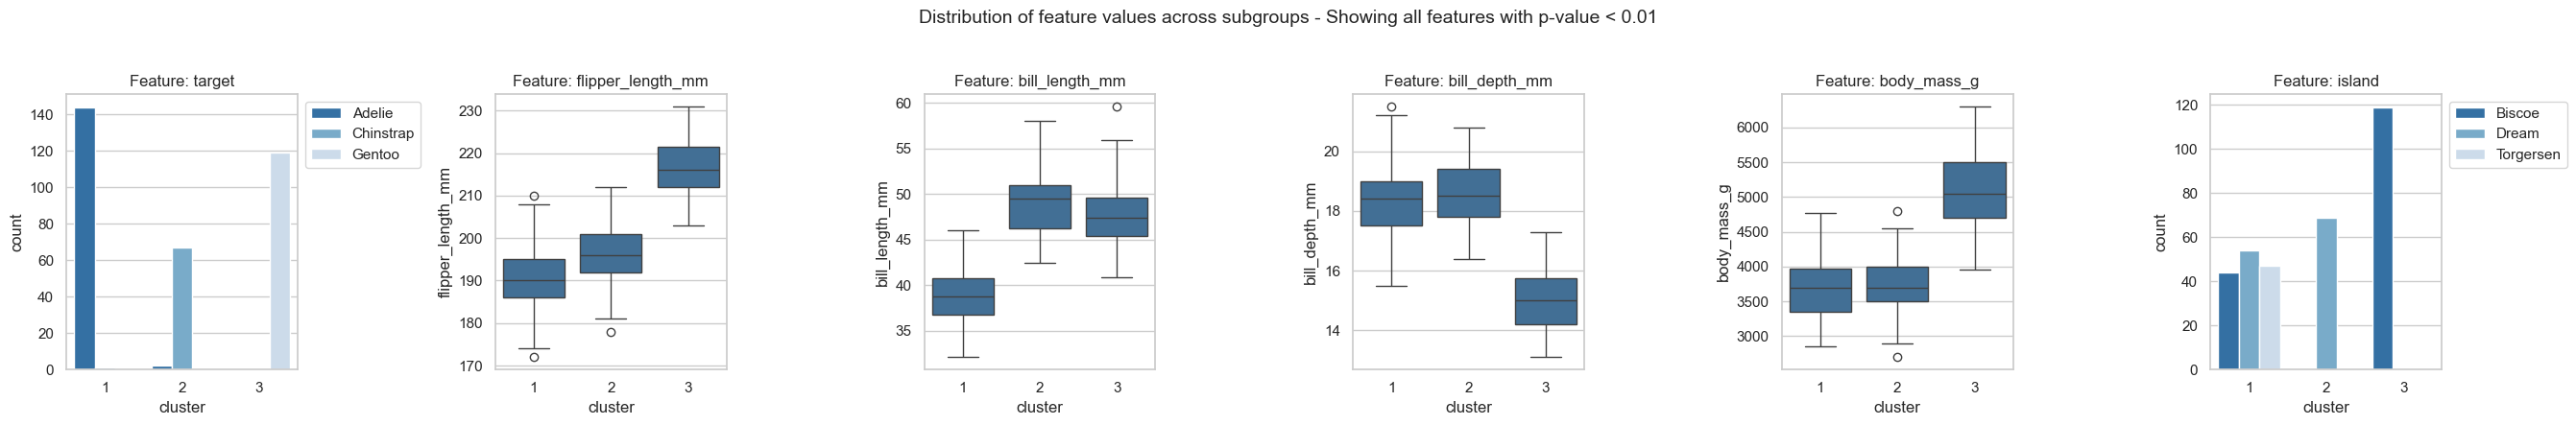

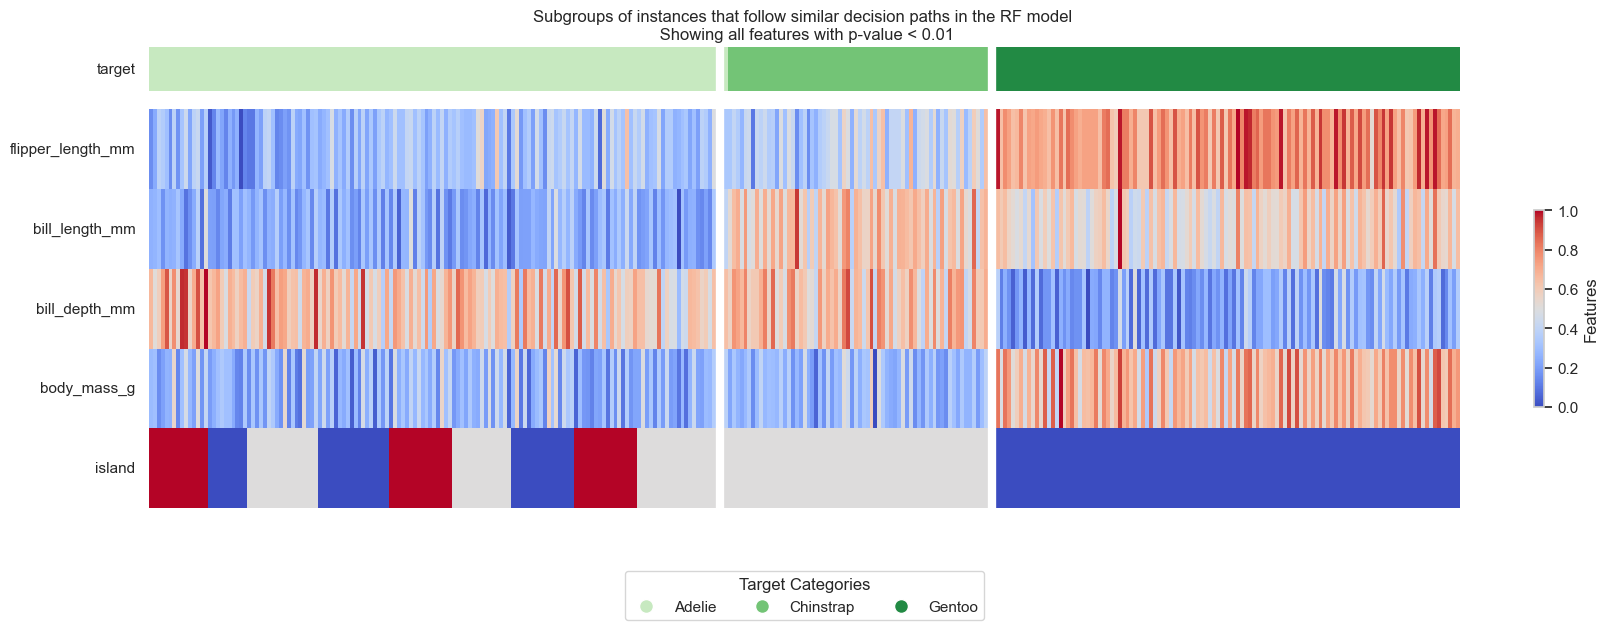

In [13]:
fgc.plot_decision_paths(thr_pvalue=0.01) # feel free to try different p-values thresholds